# Assignment 3 Text Classification with LLMs (BBCSport)


## Setup
Install required libraries.


In [ ]:
!pip -q install -U transformers==4.45.2 tokenizers==0.20.1 accelerate==0.34.2 datasets evaluate scikit-learn bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 27.8 MB/s eta 0:00:00


## Load BBCSport dataset + label distribution


In [ ]:
!test -d bbc-datasets || git clone --depth 1 https://github.com/derekgreene/bbc-datasets.git

from pathlib import Path
import pandas as pd

# auto-find bbcsport directory
root = Path("bbc-datasets")
candidates = [p for p in root.rglob("bbcsport") if p.is_dir()]
assert candidates, "bbcsport folder not found"
DATA_DIR = candidates[0]
print("Using DATA_DIR:", DATA_DIR)

def load_bbcsport_from_folders(data_dir: Path) -> pd.DataFrame:
    rows = []
    for label_dir in sorted([p for p in data_dir.iterdir() if p.is_dir()]):
        label = label_dir.name
        for txt_path in label_dir.rglob("*.txt"):
            text = txt_path.read_text(encoding="utf-8", errors="ignore").strip()
            if text:
                rows.append({"text": text, "label": label})
    return pd.DataFrame(rows)

df = load_bbcsport_from_folders(DATA_DIR).sample(frac=1, random_state=42).reset_index(drop=True)
print("Total samples:", len(df))
print(df["label"].value_counts())


Cloning into 'bbc-datasets'...
remote: Enumerating objects: 2370, done.
remote: Counting objects: 100% (2370/2370), done.
remote: Compressing objects: 100% (2367/2367), done.
remote: Total 2370 (delta 6), reused 2357 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (2370/2370), 5.78 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Using DATA_DIR: bbc-datasets/raw/bbcsport
Total samples: 737
label
football     265
rugby        147
cricket      124
athletics    101
tennis       100
Name: count, dtype: int64


## Encoder-only Transformer training (DistilBERT)
80/20 split (stratified) and fine-tune DistilBERT (encoder-only) for classification.


In [ ]:
# =========================
# Encoder-only Transformer training (DistilBERT) on BBCSport
# 80/20 stratified split + fine-tune + test accuracy
# =========================

!pip -q install -U transformers datasets accelerate evaluate scikit-learn

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from datasets import Dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

# 1) Build label mapping
labels = sorted(df["label"].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

df = df.copy()
df["label_id"] = df["label"].map(label2id)

# 2) 80/20 stratified split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"],
)

print("Train size:", len(train_df))
print("Test size :", len(test_df))
print("\nTrain label distribution:\n", train_df["label"].value_counts())
print("\nTest label distribution:\n", test_df["label"].value_counts())
print("\nLabels:", labels)

# 3) Convert pandas -> HuggingFace Dataset
train_ds = Dataset.from_pandas(train_df[["text", "label_id"]].rename(columns={"label_id": "labels"}))
test_ds  = Dataset.from_pandas(test_df[["text", "label_id"]].rename(columns={"label_id": "labels"}))

# 4) Tokenizer + tokenization
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 128

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
    )

train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("\n Tokenization done!")
print("Train_ds:", len(train_ds), "Test_ds:", len(test_ds))
print("Keys example:", train_ds[0].keys())

# 5) Model (Encoder-only) for classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

# 6) Metrics
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels_arr = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=preds, references=labels_arr)

# 7) Training config (Colab T4 safe)
training_args = TrainingArguments(
    output_dir="bbcsport_distilbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to="none",
)

# 8) Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 9) Train + Evaluate
trainer.train()
results = trainer.evaluate()
print("\n Test Accuracy (20%):", results["eval_accuracy"])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.1 MB/s eta 0:00:00
Train size: 589
Test size : 148

Train label distribution:
 label
football     212
rugby        117
cricket       99
athletics     81
tennis        80
Name: count, dtype: int64

Test label distribution:
 label
football     53
rugby        30
cricket      25
athletics    20
tennis       20
Name: count, dtype: int64

Labels: ['athletics', 'cricket', 'football', 'rugby', 'tennis']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/589 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]


 Tokenization done!
Train_ds: 589 Test_ds: 148
Keys example: dict_keys(['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'])


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.586261,0.986486
2,0.959416,0.210663,0.993243
3,0.249141,0.152108,0.993243


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



 Test Accuracy (20%): 0.9932432432432432


## Prompt design (System / User / Assistant)


In [ ]:
print("STEP 1: Define possible labels")
LABELS = ["athletics", "cricket", "football", "rugby", "tennis"]
print("Available Labels:", LABELS)
print("="*70)


print("\nSTEP 2: Create System Prompt")
SYSTEM_PROMPT = (
    "[System]\n"
    "You are a strict BBC Sports topic classifier.\n"
    "Your task is to classify BBC sports news articles.\n"
    "You must output ONLY one label from: athletics, cricket, football, rugby, tennis.\n"
    "No explanation. No punctuation. No extra text.\n"
)
print(SYSTEM_PROMPT)
print("="*70)


print("\nSTEP 3: Create User Prompt Template")
USER_PROMPT_TEMPLATE = (
    "[User]\n"
    "Classify the following BBC Sports article into exactly one label.\n\n"
    "Article:\n{text}\n\n"
    "Return only the label."
)
print(USER_PROMPT_TEMPLATE.format(text="<<ARTICLE TEXT HERE>>"))
print("="*70)


print("\nSTEP 4: Define Expected Assistant Output Format")
ASSISTANT_EXAMPLE = "[Assistant]\nfootball"
print(ASSISTANT_EXAMPLE)
print("="*70)


print("\nPrompt design completed successfully ")


STEP 1: Define possible labels
Available Labels: ['athletics', 'cricket', 'football', 'rugby', 'tennis']

STEP 2: Create System Prompt
[System]
You are a strict BBC Sports topic classifier.
Your task is to classify BBC sports news articles.
You must output ONLY one label from: athletics, cricket, football, rugby, tennis.
No explanation. No punctuation. No extra text.


STEP 3: Create User Prompt Template
[User]
Classify the following BBC Sports article into exactly one label.

Article:
<<ARTICLE TEXT HERE>>

Return only the label.

STEP 4: Define Expected Assistant Output Format
[Assistant]
football

Prompt design completed successfully 


## 200 balanced samples (40 per class)


In [ ]:
SAMPLES_PER_CLASS = 40

balanced_df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=SAMPLES_PER_CLASS, random_state=42))
      .reset_index(drop=True)
).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced set size:", len(balanced_df))
print(balanced_df["label"].value_counts())


Balanced set size: 200
label
football     40
athletics    40
rugby        40
cricket      40
tennis       40
Name: count, dtype: int64


/tmp/ipython-input-1474187836.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=SAMPLES_PER_CLASS, random_state=42))


## LLM evaluation (5 models on 200 samples)
Models executed in Colab (open-weights):
- Qwen/Qwen2.5-1.5B-Instruct
- Qwen/Qwen2.5-0.5B-Instruct
- TinyLlama/TinyLlama-1.1B-Chat-v1.0
- HuggingFaceTB/SmolLM2-1.7B-Instruct
- bigscience/bloomz-560m

**Note:** Some popular LLMs (ChatGPT, Gemini, Llama, DeepSeek) were explored but not executed due to API keys / gated access / Colab compatibility constraints.


In [ ]:
import pandas as pd

# Raw results
results_df = pd.DataFrame([
    {"Model (LLM)": "Qwen/Qwen2.5-1.5B-Instruct", "Organization": "Alibaba (Qwen)", "Open-source / Open-weights": "Open-weights", "Accuracy": 0.945},
    {"Model (LLM)": "Qwen/Qwen2.5-0.5B-Instruct", "Organization": "Alibaba (Qwen)", "Open-source / Open-weights": "Open-weights", "Accuracy": 0.645},
    {"Model (LLM)": "TinyLlama/TinyLlama-1.1B-Chat-v1.0", "Organization": "Community (TinyLlama)", "Open-source / Open-weights": "Open-weights", "Accuracy": 0.400},
    {"Model (LLM)": "bigscience/bloomz-560m", "Organization": "BigScience", "Open-source / Open-weights": "Open-weights", "Accuracy": 0.080},
    {"Model (LLM)": "HuggingFaceTB/SmolLM2-1.7B-Instruct", "Organization": "HuggingFaceTB", "Open-source / Open-weights": "Open-weights", "Accuracy": 0.000},
])

# Sort by accuracy
results_df = results_df.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# Add Rank
results_df["Rank"] = results_df.index + 1

# Accuracy percentage
results_df["Accuracy (%)"] = (results_df["Accuracy"] * 100).round(2)

# Correct predictions out of 200
results_df["Correct Predictions"] = (results_df["Accuracy"] * 200).round().astype(int)
results_df["Correct / 200"] = results_df["Correct Predictions"].astype(str) + "/200"

# Final column order
results_df = results_df[
    ["Rank", "Model (LLM)", "Organization",
     "Open-source / Open-weights",
     "Accuracy", "Accuracy (%)", "Correct / 200"]
]

# Hide pandas default index for clean look
results_df.style.hide(axis="index")


Rank,Model (LLM),Organization,Open-source / Open-weights,Accuracy,Accuracy (%),Correct / 200
1,Qwen/Qwen2.5-1.5B-Instruct,Alibaba (Qwen),Open-weights,0.945000,94.500000,189/200
2,Qwen/Qwen2.5-0.5B-Instruct,Alibaba (Qwen),Open-weights,0.645000,64.500000,129/200
3,TinyLlama/TinyLlama-1.1B-Chat-v1.0,Community (TinyLlama),Open-weights,0.400000,40.000000,80/200
4,bigscience/bloomz-560m,BigScience,Open-weights,0.080000,8.000000,16/200
5,HuggingFaceTB/SmolLM2-1.7B-Instruct,HuggingFaceTB,Open-weights,0.000000,0.000000,0/200


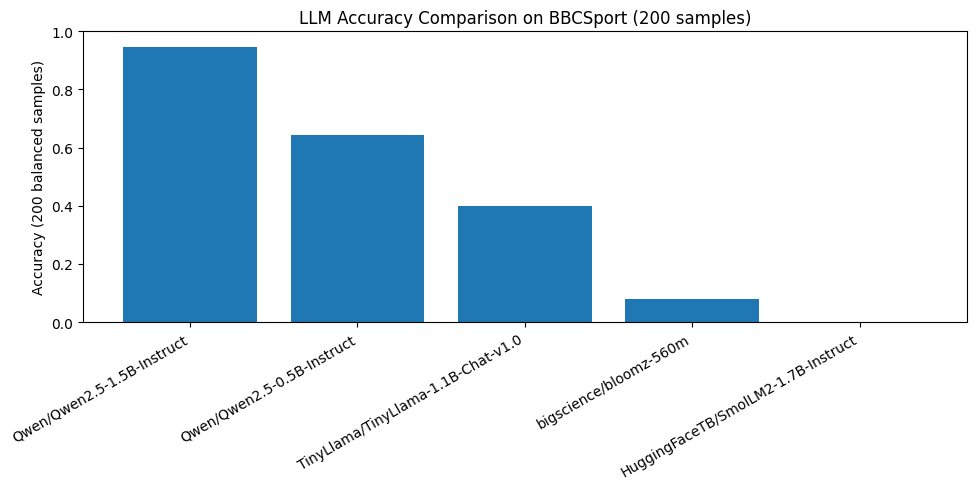

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(results_df["Model (LLM)"], results_df["Accuracy"])
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1.0)
plt.ylabel("Accuracy (200 balanced samples)")
plt.title("LLM Accuracy Comparison on BBCSport (200 samples)")
plt.tight_layout()
plt.show()


## Conclusion


*  The encoder-only Transformer model (DistilBERT) achieved 99.32% test accuracy on the 20% held-out dataset, demonstrating the strong effectiveness of fine-tuned encoder-based architectures for supervised text classification.

*  For LLM-based zero/few-shot classification on the 200 balanced samples, Qwen Qwen2.5-1.5B-Instruct achieved the highest performance (94.5% accuracy), correctly classifying 189 out of 200 instances.

*  Performance decreased with smaller or less instruction-aligned models, highlighting that model scale, instruction tuning, and architecture significantly influence classification reliability.

*  Overall, while encoder fine-tuning achieved the highest accuracy, strong instruction-tuned LLMs demonstrated competitive performance without additional training.

## Lessons learned


1) **Balanced evaluation is essential**
Using an equal number of samples per class (40 each) prevents majority-class bias and ensures fair model comparison.

2) **Prompt design directly impacts LLM performance**
Strict “label-only” output constraints significantly improved evaluation reliability and reduced noisy responses.

3) **Model size and instruction tuning matter**
Larger and better instruction-aligned models (e.g., Qwen 1.5B) outperformed smaller or loosely tuned models, showing that architectural and training differences strongly affect downstream NLP performance.

4) **Practical constraints influence experimentation**
API access limitations, gated licenses, and library compatibility issues can restrict which LLMs are feasible to evaluate in environments like Google Colab.
